## import modules

In [1]:
# Import basic modules
import math
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Ignore some annoying warnings
from datetime import datetime

# Import module for EMD decomposition
# It is the EMD-signal module with different name to import
from PyEMD import EMD,EEMD,CEEMDAN,Visualisation #For module 'PyEMD', please use 'pip install EMD-signal' instead.

# Import modules for LSTM prediciton
# Sklearn
from sklearn.preprocessing import MinMaxScaler # Normalization
from sklearn.metrics import r2_score # R2
from sklearn.metrics import mean_squared_error # MSE
from sklearn.metrics import mean_absolute_error # MAE
from sklearn.metrics import mean_absolute_percentage_error # MAPE


# Statistical tests
from statsmodels.tsa.stattools import adfuller # adf_test
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test # LB_test
from statsmodels.stats.stattools import jarque_bera as jb_test # JB_test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # plot_acf_pacf

from sklearn.preprocessing import StandardScaler

import yfinance as yf

from xgboost import XGBRegressor as XGBR

In [2]:
data = yf.download("^HSI", start="2017-07-26", end="2022-07-26")

[*********************100%***********************]  1 of 1 completed


In [3]:
data = data.iloc[:,[0,1,2,3,5]]
#data.index = range(len(data))

In [4]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-07-26,26960.810547,27007.269531,26786.630859,26941.019531,2176480400
2017-07-27,27002.699219,27169.150391,26962.029297,27131.169922,1763945900
2017-07-28,27007.970703,27047.880859,26928.439453,26979.390625,1456040200
2017-07-31,27048.449219,27324.380859,27045.410156,27323.990234,1693214100
2017-08-01,27326.039062,27558.000000,27326.039062,27540.230469,2392422600


In [5]:
data.shape

(1231, 5)

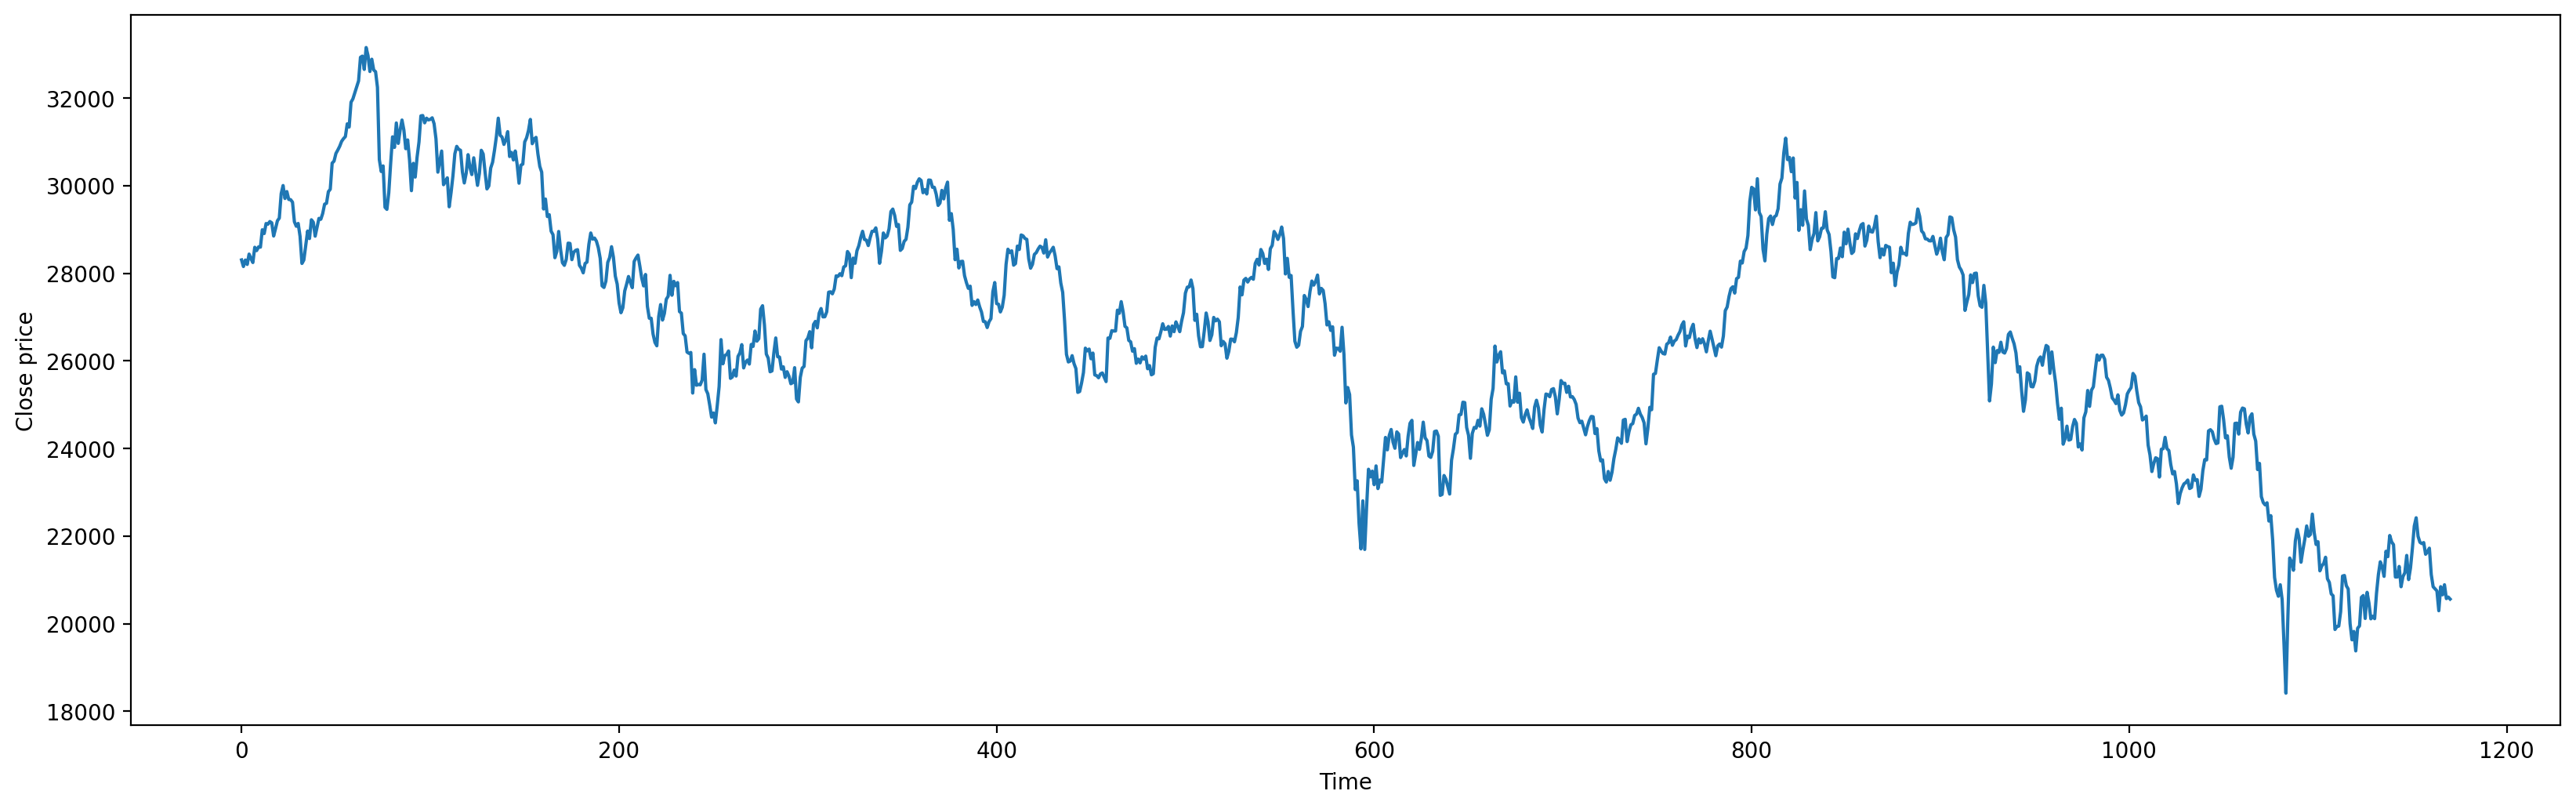

In [107]:
plt.figure(figsize=(20,6),dpi=200)
plt.plot(data['Close'])
plt.ylabel('Close price')
plt.xlabel('Time')
plt.show()

# generate features

In [6]:
import talib
def features(dataset):
    for i in [5,10,20,60]:
        window = i
        # Volatility
        dataset[str('SMA'+str(i))] = talib.SMA(dataset['Close'],timeperiod=window).shift(1)
        dataset[str('EMA'+str(i))] = talib.EMA(dataset['Close'],timeperiod=window).shift(1)
        dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['Close'],timeperiod=window).shift(1)
        dataset[str('Lag'+str(i))] = dataset['Close'].shift(i)
    return dataset

In [7]:
data = features(data)

In [8]:
data = data.iloc[60:,:]
data.index = range(len(data))
data.shape

(1171, 21)

In [9]:
data.head()

,Open,High,Low,Close,Volume,SMA5,EMA5,STDDEV5,Lag5,SMA10,...,STDDEV10,Lag10,SMA20,EMA20,STDDEV20,Lag20,SMA60,EMA60,STDDEV60,Lag60
0,28557.800781,28557.800781,28253.320312,28305.880859,1712055400,28549.676172,28471.317898,212.160632,28692.800781,28489.083008,...,167.568349,28326.589844,28176.189941,28271.007228,424.844184,28110.330078,27793.300846,27793.300846,459.334291,26941.019531
1,28232.619141,28356.099609,28098.830078,28154.970703,1426893600,28472.292187,28416.172219,216.365785,28697.490234,28487.012109,...,169.678410,28490.830078,28185.967480,28274.328527,425.465734,27880.529297,27816.048535,27810.106748,450.270045,27131.169922
2,28238.849609,28387.210938,28198.560547,28302.890625,1272809300,28363.788281,28329.105047,212.218774,28711.759766,28453.426172,...,196.688687,28389.570312,28199.689551,28262.961115,419.781147,27500.339844,27833.111882,27821.413763,443.338224,26979.390625
3,28165.609375,28316.199219,28102.750000,28202.380859,1431611800,28282.014453,28320.366906,121.961974,28159.089844,28444.758203,...,201.170683,28459.029297,28239.817090,28266.763925,388.180389,27513.009766,27855.170215,27837.199890,433.120167,27323.990234
4,28332.910156,28494.519531,28305.730469,28438.849609,2255521100,28290.672656,28281.038224,114.218950,28487.240234,28419.093359,...,213.694340,28476.429688,28274.285645,28260.632205,350.932419,27642.429688,27869.810059,27849.173036,429.750476,27540.230469


# 2. evalution functions

In [10]:
SERIES = pd.Series(data['Close'].values)

In [12]:
# Model evaluation function
def evl(y_test, y_pred): # MSE and MAE are different on different scales
    y_test,y_pred = np.array(y_test).ravel(),np.array(y_pred).ravel()
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)*100
    print('Model Evaluation ')
    print('R2:', r2)
    print('RMSE:', rmse)
    print('MAE:', mae)
    print("MAPE:",mape) # MAPE before normalization may error beacause of negative values
    return [r2,rmse,mae,mape]

In [13]:
# Plot original data and forecasting data
def plot_all(pred_ans,PERIODS):
    # Check and Change
    pred_ans = pred_ans.ravel()
    og = pd.Series(SERIES[-PERIODS:].values)

    # Plot
    fig = plt.figure(figsize=(10,4))
    
    plt.plot(og,label= 'Original data', color='#0070C0') #F27F19 orange #0070C0 blue
    plt.plot(pred_ans,label= 'Forecasting data', color='#F27F19')
    plt.xlabel('')
    plt.title('forecasting results')
    plt.legend()
              
    plt.show()
    return 

# 3.prediction function

In [14]:
#without scaler
# DATE_BACK functions for inputting sets
def create_dateback(df,DATE_BACK=5,ahead = 1):
    if isinstance(df, pd.DataFrame):
        trainX = df.drop('Close', axis=1, inplace=False)
        #scalarX =MinMaxScaler(feature_range=(0,1))#sklearn normalize
        #trainX = scalarX.fit_transform(trainX)
        trainY = np.array(df['Close']).reshape(-1, 1)
        #scalarY = MinMaxScaler(feature_range=(0,1))#sklearn normalize
        #trainY = scalarY.fit_transform(trainY)
    # Normalize for each IMF in Series
    else:
        trainY = np.array(df.values).reshape(-1, 1)
        #scalarY = MinMaxScaler(feature_range=(0,1))#sklearn normalize
        #trainY = scalarY.fit_transform(trainY)
        trainX = trainY
    
    # Create dateback
    dataX, dataY = [], []
    ahead = ahead - 1
    for i in range(len(trainY)-DATE_BACK-ahead):
        dataX.append(np.array(trainX[i:(i+DATE_BACK)]))
        dataY.append(np.array(trainY[i+DATE_BACK+ahead]))
        
    return np.array(dataX),np.array(dataY)

In [15]:
def step_linear_model(df,model_type,ahead = 1):
    trainX,trainY = create_dateback(df)
    X0_train,X0_test = trainX[:-ahead],trainX[-ahead:]
    y0_train = trainY[:-ahead]
    
    X0_train = X0_train.reshape(X0_train.shape[0],-1)
    X0_test = X0_test.reshape(X0_test.shape[0],-1)
    y0_train = y0_train.reshape(y0_train.shape[0])
    
    #define linear model
    if model_type == 'LR':
        regressor = LinearRegression()
    if model_type =='Lasso':
        regressor = Lasso(alpha=0.1)
    if model_type == 'Ridge':
        regressor = Ridge()
    if model_type == 'Xgboost':
        regressor = XGBR()
    if model_type == 'SVR':
        regressor = SVR()
    
    #print(X0_train.shape)
    #print(y0_train.shape)
    model = regressor.fit(X0_train,y0_train)
    # prediction on test set
    y_pred = model.predict(X0_test)
    
    return y_pred[0]

# bench

In [16]:
data.head()

,Open,High,Low,Close,Volume,SMA5,EMA5,STDDEV5,Lag5,SMA10,...,STDDEV10,Lag10,SMA20,EMA20,STDDEV20,Lag20,SMA60,EMA60,STDDEV60,Lag60
0,28557.800781,28557.800781,28253.320312,28305.880859,1712055400,28549.676172,28471.317898,212.160632,28692.800781,28489.083008,...,167.568349,28326.589844,28176.189941,28271.007228,424.844184,28110.330078,27793.300846,27793.300846,459.334291,26941.019531
1,28232.619141,28356.099609,28098.830078,28154.970703,1426893600,28472.292187,28416.172219,216.365785,28697.490234,28487.012109,...,169.678410,28490.830078,28185.967480,28274.328527,425.465734,27880.529297,27816.048535,27810.106748,450.270045,27131.169922
2,28238.849609,28387.210938,28198.560547,28302.890625,1272809300,28363.788281,28329.105047,212.218774,28711.759766,28453.426172,...,196.688687,28389.570312,28199.689551,28262.961115,419.781147,27500.339844,27833.111882,27821.413763,443.338224,26979.390625
3,28165.609375,28316.199219,28102.750000,28202.380859,1431611800,28282.014453,28320.366906,121.961974,28159.089844,28444.758203,...,201.170683,28459.029297,28239.817090,28266.763925,388.180389,27513.009766,27855.170215,27837.199890,433.120167,27323.990234
4,28332.910156,28494.519531,28305.730469,28438.849609,2255521100,28290.672656,28281.038224,114.218950,28487.240234,28419.093359,...,213.694340,28476.429688,28274.285645,28260.632205,350.932419,27642.429688,27869.810059,27849.173036,429.750476,27540.230469


## 4.XGBOOST

In [17]:
test_num = int(data.shape[0]*0.2)

In [47]:
test_num

234

In [46]:
data.shape[0]-test_num

937

In [18]:
from xgboost import XGBRegressor as XGBR
pred_Xgboost= []
for i in range(test_num,0,-1):
    if (-i+1) != 0:
        df = data[:-i+1]
        pred_Xgboost.append(step_linear_model(df,'Xgboost'))
    elif (-i+1) == 0:
        df = data
        pred_Xgboost.append(step_linear_model(df,'Xgboost'))

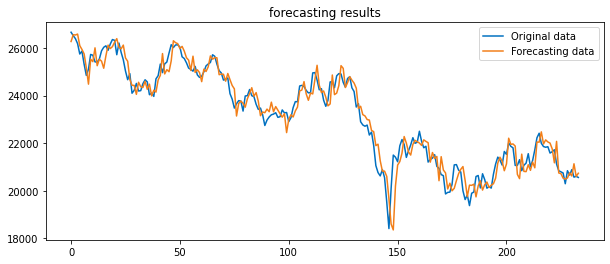

In [19]:
plot_all(pd.array(pred_Xgboost[:]),PERIODS=test_num) 

In [48]:
evl1 = evl(SERIES[-test_num:].values, pred_Xgboost)

Model Evaluation 
R2: 0.9364026917613585
RMSE: 496.39774461807104
MAE: 374.08480235042737
MAPE: 1.655815441344203


# denoising

In [19]:
# 3.Decomposition, Sample entropy, Re-decomposition, and Integration
# EMD decomposition
# -------------------------------
# Decompose adaptively and plot function
# Residue is named the last IMF
#for show
def emd_decom(series,MODE,trials=10,draw=True): 
    # Check input
    series = series.values

    # Initialization
    #print('%s decomposition is running.'%str.upper(MODE))
    if MODE == 'emd':decom = EMD()
    elif MODE == 'eemd':decom = EEMD()
    elif MODE == 'ceemdan':decom = CEEMDAN()
        
    # Decompose
    decom.trials = trials # Number of the white noise input
    imfs_emd = decom(series)
    imfs_num = np.shape(imfs_emd)[0]

    if draw:
        # Plot original data
        series_index = range(len(series))
        fig = plt.figure(figsize=(16,2*imfs_num))
        plt.subplot(1+imfs_num, 1, 1 )
        plt.plot(series_index, series, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('Original data')
    
    
        
        # Plot IMFs
        for i in range(imfs_num):
            plt.subplot(1 + imfs_num,1,2 + i)
            plt.plot(series_index, imfs_emd[i, :], color='#F27F19')
            plt.ylabel(str.upper(MODE)+'-IMF'+str(i))
        plt.savefig('example of decomposition.jpg')
    
    imfs_df = pd.DataFrame(imfs_emd.T)
    imfs_df.columns = ['imf'+str(i) for i in range(imfs_num)]

    return imfs_df # pd.DataFrame

,imf0,imf1,imf2,imf3,imf4,imf5,imf6
0,63.129861,-15.598534,-5.964422,-490.809537,-983.209343,-917.153175,30655.486009
1,-63.648205,-38.834404,6.591191,-494.765640,-989.846079,-919.179325,30654.653164
2,72.784704,-23.061826,4.653738,-487.960758,-996.801337,-920.396165,30653.672271
3,-94.007850,38.539901,-2.226832,-467.723060,-1003.952705,-920.791325,30652.542729
4,112.202980,41.802053,-2.988045,-431.927876,-1011.151007,-920.352434,30651.263938
...,...,...,...,...,...,...,...
1166,-143.600871,229.204951,-669.487966,-510.231150,903.598244,-3946.563641,24798.140980
1167,104.754372,212.694419,-672.300132,-513.954608,908.032874,-3946.099739,24797.093517
1168,-76.050767,60.291608,-657.809963,-512.520529,909.973692,-3945.327628,24796.074446
1169,65.792385,-82.550061,-628.207141,-506.201833,909.470098,-3944.246609,24795.083785


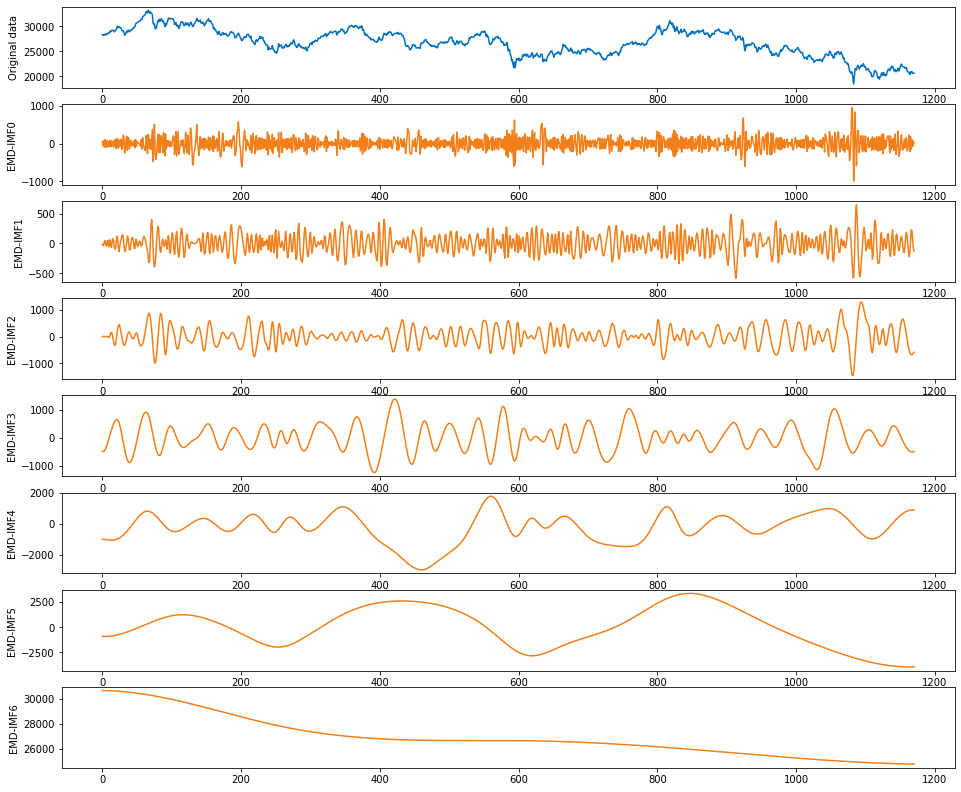

In [20]:
emd_decom(SERIES,'emd',trials=10,draw=True)

In [22]:
from PyEMD.checks import whitenoise_check
def emd_denoise(mode,series,show = False):
    if mode == 'emd':
        decom = EMD()
    elif mode == 'eemd':
        decom = EEMD()
    elif mode == 'ceemdan':
        decom = CEEMDAN()
    imfs = decom(series)
    significant_imfs = whitenoise_check(imfs,alpha = 0.95)
    denoised_data = np.array([0]*len(series))
    if show:print(significant_imfs)
    for i in significant_imfs:
        if significant_imfs[i] ==1:
            denoised_data = denoised_data+imfs[i-1]
    return denoised_data,imfs.shape[0]

In [23]:
def denoise_1(de_data,df):
    de_df = df.drop(axis = 1, columns = 'Close',inplace = False)
    de_df['de_close'] = pd.DataFrame(de_data)
    return de_df

In [24]:
#without scaler
# DATE_BACK functions for inputting sets
def df_dateback(df,DATE_BACK=5,ahead = 1):
    trainX = df.drop('de_close', axis=1, inplace=False)
    trainY = np.array(df['de_close']).reshape(-1, 1)
    
    # Create dateback
    dataX, dataY = [], []
    ahead = ahead - 1
    for i in range(len(trainY)-DATE_BACK):
        dataX.append(np.array(trainX[i:(i+DATE_BACK)]))
        dataY.append(np.array(trainY[i+DATE_BACK]))
    dataX.append(np.array(trainX[-DATE_BACK:]))
        
    return np.array(dataX),np.array(dataY)

In [25]:
def denoise_pred(df,model_type,ahead = 1):
    trainX,trainY = df_dateback(df)
    X0_train,X0_test = trainX[:-ahead],trainX[-ahead:]
    y0_train = trainY
    
    X0_train = X0_train.reshape(X0_train.shape[0],-1)
    X0_test = X0_test.reshape(X0_test.shape[0],-1)
    y0_train = y0_train.reshape(y0_train.shape[0])
    
    #define linear model
    if model_type == 'LR':
        regressor = LinearRegression()
    if model_type =='Lasso':
        regressor = Lasso(alpha=0.1)
    if model_type == 'Ridge':
        regressor = Ridge()
    if model_type == 'Xgboost':
        regressor = XGBR()
    if model_type == 'SVR':
        regressor = SVR()
    
    
    #print(X0_train.shape)
    #print(y0_train.shape)
    model = regressor.fit(X0_train,y0_train)
    # prediction on test set
    y_pred = model.predict(X0_test)
    
    return y_pred[0]

# 1.emd

In [26]:
emd_pred_Xgboost = []
emd_num = []
for i in range(test_num,0,-1):
    print(test_num-i)
    series = SERIES[:-i]
    de_df = data[:-i]
    denoised_data,n = emd_denoise('emd',series.values)
    emd_num.append(n)
    de_df = denoise_1(denoised_data,de_df)
    emd_pred_Xgboost.append(denoise_pred(de_df,'Xgboost'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


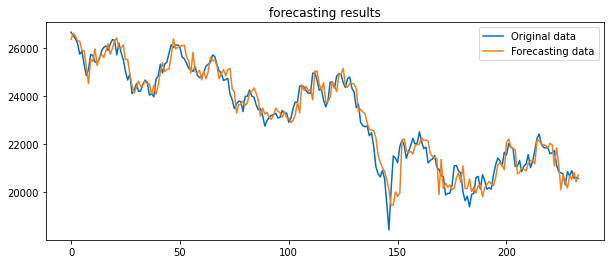

In [27]:
plot_all(pd.array(emd_pred_Xgboost[:]),PERIODS=test_num)

In [71]:
evl2 = evl(SERIES[-test_num:].values, emd_pred_Xgboost)

Model Evaluation 
R2: 0.938712468793912
RMSE: 487.30009501901856
MAE: 361.3653762686966
MAPE: 1.602412358881124


# 2. ceemdan

In [29]:
ceemdan_pred_Xgboost= []
for i in range(test_num,0,-1):
    print(test_num-i)
    series = SERIES[:-i]
    de_df = data[:-i]
    denoised_data,n = emd_denoise('ceemdan',series.values,show = True)
    de_df = denoise_1(denoised_data,de_df)
    ceemdan_pred_Xgboost.append(denoise_pred(de_df,'Xgboost'))

0
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
1
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
2
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
3
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
4
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
5
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
6
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
7
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
8
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
9
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
10
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
11
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
12
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
13
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
14
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
15
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
16
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
17
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
18
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
19
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
20
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
21
{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1

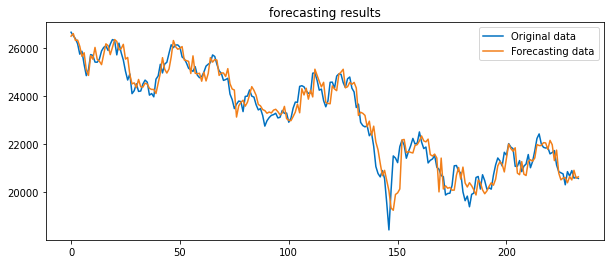

In [30]:
plot_all(pd.array(ceemdan_pred_Xgboost[:]),PERIODS=test_num) 

In [72]:
evl3 =evl(SERIES[-test_num:].values, ceemdan_pred_Xgboost)

Model Evaluation 
R2: 0.9409288010953061
RMSE: 478.4078806778623
MAE: 354.8312800480769
MAPE: 1.575212601878127


# VMD-DFA

In [32]:
import fathon
from fathon import fathonUtils as fu

In [33]:
def calculate_H(array):
    a = fu.toAggregated(array)
    pydfa = fathon.DFA(a)
    wins = fu.linRangeByStep(4,16)
    n,F = pydfa.computeFlucVec(wins)
    H,H_intercept = pydfa.fitFlucVec()
    return H

In [34]:
def plot_dfa(H_list):
    plt.plot(H_list)
    plt.axhline(0.75,color = 'red')
    plt.xlabel('IMF')
    plt.show()

In [35]:
def J_number(num):
    if num <= 0.75:
        J = 1
    elif num> 0.75 and num <= 1.0:
        J = 2
    elif num > 1 and num <= 1.5:
        J = 3
    else:
        J = 4
    return J

In [36]:
def K_num(series,J):
    K = 1
    num = 0
    while (num < 20):
        num = 0
        vmf_imfs = vmd_decom(series,K,draw=False)
        for i in vmf_imfs.columns:
            if calculate_H(vmf_imfs[i]) >= 0.75:
                num = num +1
        if num > J:
                return K-1
        K = K + 1
    #the Max K
    #K = K -1
    #return K

In [37]:
# VMD # There are some problems in this module
# -------------------------------
def vmd_decom(series,K,draw = False):
    from vmdpy import VMD  
    # VMD parameters
    alpha = 2000       # moderate bandwidth constraint  
    tau = 0.           # noise-tolerance (no strict fidelity enforcement)  
    DC = 0             # no DC part imposed  
    init = 1           # initialize omegas uniformly  
    tol = 1e-7         

    # VMD 
    imfs_vmd, imfs_hat, omega = VMD(series, alpha, tau, K, DC, init, tol)  
    imfs_num = np.shape(imfs_vmd)[0]
    
    if draw:
        # Plot original data
        fig = plt.figure(figsize=(16,2*imfs_num))
        plt.subplot(1+imfs_num, 1, 1 )
        plt.plot(series, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('VMD Original data')
    
        # Plot IMFs
        for i in range(imfs_num):
            plt.subplot(1 + imfs_num,1,2 + i)
            plt.plot(imfs_vmd[i, :], color='#F27F19')
            plt.ylabel('VMD-IMF'+str(i))
            
        plt.show()
    
    # Save data
    imfs_df = pd.DataFrame(imfs_vmd.T)
    imfs_df.columns = ['imf'+str(i) for i in range(imfs_num)]

    return imfs_df # pd.DataFrame

In [38]:
def put_databack(series,reconstructed_data,df):
    if len(series) > len(reconstructed_data):
        reconstructed_data = list(reconstructed_data)
        reconstructed_data.insert(0,reconstructed_data[0])

    de_df = df
    de_df.drop(axis = 1, columns = 'Close',inplace = True)
    de_df['de_close'] = pd.DataFrame(reconstructed_data)
    return de_df

In [39]:
#one example
VMD_Xgboost= []
alpha0_list = []
for i in range(test_num,0,-1):
    print(test_num-i)
    series = SERIES[:-i]
    alpha0 = calculate_H(series)
    J = J_number(alpha0)
    K = K_num(series,J)
    #print(J,K)
    vmf_imfs = vmd_decom(series,K,draw=False)
    #H_list = []
    #for i in vmf_imfs.columns:
        #H_list.append(calculate_H(vmf_imfs[i]))
    #plot_dfa(H_list) 
    #print(H_list)
    #reconstruct data
    reconstructed_data = vmf_imfs.iloc[:,:J].sum(axis = 1)
    df = data[:-i]
    de_df = put_databack(series,reconstructed_data,df)
    #print(de_df)
    VMD_Xgboost.append(denoise_pred(de_df,'Xgboost'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


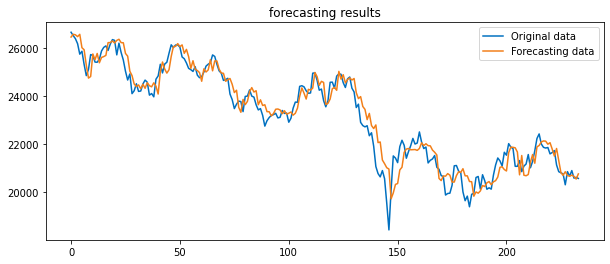

In [40]:
plot_all(pd.array(VMD_Xgboost[:]),PERIODS=test_num)

In [73]:
evl4 =evl(SERIES[-test_num:].values, VMD_Xgboost)

Model Evaluation 
R2: 0.9291145372067393
RMSE: 524.0696649871498
MAE: 395.3323150373932
MAPE: 1.7644431883692822


# VMD-EMD-DFA

In [42]:
VMD_EMD_Xgboost= []
alpha0_list = []
for i in range(test_num,0,-1):
    print(test_num-i)
    series = SERIES[:-i]
    #print(test_num-i)
    vmf_imfs = vmd_decom(series,emd_num[test_num-i],draw=False)
    #emd_num[0]
    #H_list = []
    col_num = []
    no = 0
    for j in vmf_imfs.columns:
        if calculate_H(vmf_imfs[j]) >= 0.75:
            col_num.append(no)
        no = no+1
         
    #plot_dfa(H_list) 
    #print(H_list)
    #reconstruct data
    reconstructed_data = vmf_imfs.iloc[:,col_num].sum(axis = 1)
    print(col_num)
    df = data[:-i]
    de_df = put_databack(series,reconstructed_data,df)
    VMD_EMD_Xgboost.append(denoise_pred(de_df,'Xgboost'))

0
[0, 1, 2, 3, 4]
1
[0, 1, 2, 3, 4]
2
[0, 1, 2, 3, 4]
3
[0, 1, 2, 3, 4]
4
[0, 1, 2, 3, 4]
5
[0, 1, 2, 3, 4]
6
[0, 1, 2, 3, 4]
7
[0, 1, 2, 3, 4]
8
[0, 1, 2, 3, 4]
9
[0, 1, 2, 3, 4]
10
[0, 1, 2, 3, 4]
11
[0, 1, 2, 3, 4]
12
[0, 1, 2, 3, 4]
13
[0, 1, 2, 3, 4]
14
[0, 1, 2, 3, 4]
15
[0, 1, 2, 3, 4]
16
[0, 1, 2, 3, 4]
17
[0, 1, 2, 3, 4]
18
[0, 1, 2, 3, 4]
19
[0, 1, 2, 3, 4]
20
[0, 1, 2, 3, 4]
21
[0, 1, 2, 3, 4]
22
[0, 1, 2, 3, 4]
23
[0, 1, 2, 3, 4]
24
[0, 1, 2, 3, 4]
25
[0, 1, 2, 3, 4]
26
[0, 1, 2, 3, 4]
27
[0, 1, 2, 3, 4]
28
[0, 1, 2, 3, 4]
29
[0, 1, 2, 3, 4]
30
[0, 1, 2, 3, 4]
31
[0, 1, 2, 3, 4]
32
[0, 1, 2, 3, 4]
33
[0, 1, 2, 3, 4]
34
[0, 1, 2, 3, 4]
35
[0, 1, 2, 3, 4]
36
[0, 1, 2, 3, 4]
37
[0, 1, 2, 3, 4]
38
[0, 1, 2, 3, 4]
39
[0, 1, 2, 3, 4]
40
[0, 1, 2, 3, 4]
41
[0, 1, 2, 3, 4]
42
[0, 1, 2, 3, 4]
43
[0, 1, 2, 3, 4]
44
[0, 1, 2, 3, 4]
45
[0, 1, 2, 3, 4]
46
[0, 1, 2, 3, 4]
47
[0, 1, 2, 3, 4]
48
[0, 1, 2, 3, 4]
49
[0, 1, 2, 3, 4]
50
[0, 1, 2, 3, 4]
51
[0, 1, 2, 3, 4]
52
[0, 1, 2, 3, 4]
53


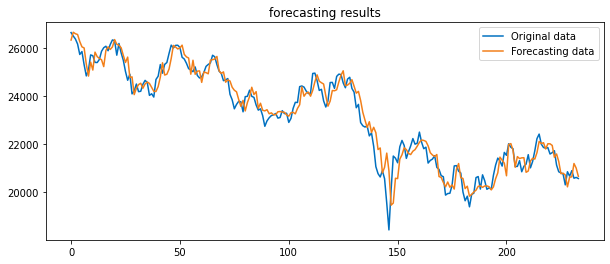

In [43]:
plot_all(pd.array(VMD_EMD_Xgboost[:]),PERIODS=test_num)

In [108]:
evl5 =evl(SERIES[-test_num:].values, VMD_EMD_Xgboost)

Model Evaluation 
R2: 0.9414651438886102
RMSE: 476.23105239229096
MAE: 354.10588608440173
MAPE: 1.5674628196461866


# evl

In [103]:
evl_df = pd.DataFrame([evl1,evl2,evl3,evl4,evl5])
evl_df.index = ['Benchmark','EMD','CEEMDAN','VMD-DFA','VMD-EMD-DFA']
evl_df.columns = ['R2','RMSE','MAE','MAPE']

In [104]:
evl_df

,R2,RMSE,MAE,MAPE
Benchmark,0.936403,496.397745,374.084802,1.655815
EMD,0.938712,487.300095,361.365376,1.602412
CEEMDAN,0.940929,478.407881,354.831280,1.575213
VMD-DFA,0.929115,524.069665,395.332315,1.764443
VMD-EMD-DFA,0.941465,476.231052,354.105886,1.567463


In [100]:
evl_df.to_csv('HSI evl.csv' )

# plot all

In [96]:
example = yf.download("^HSI", start="2017-07-26", end="2022-07-26")
date = example.index[-test_num:]

[*********************100%***********************]  1 of 1 completed


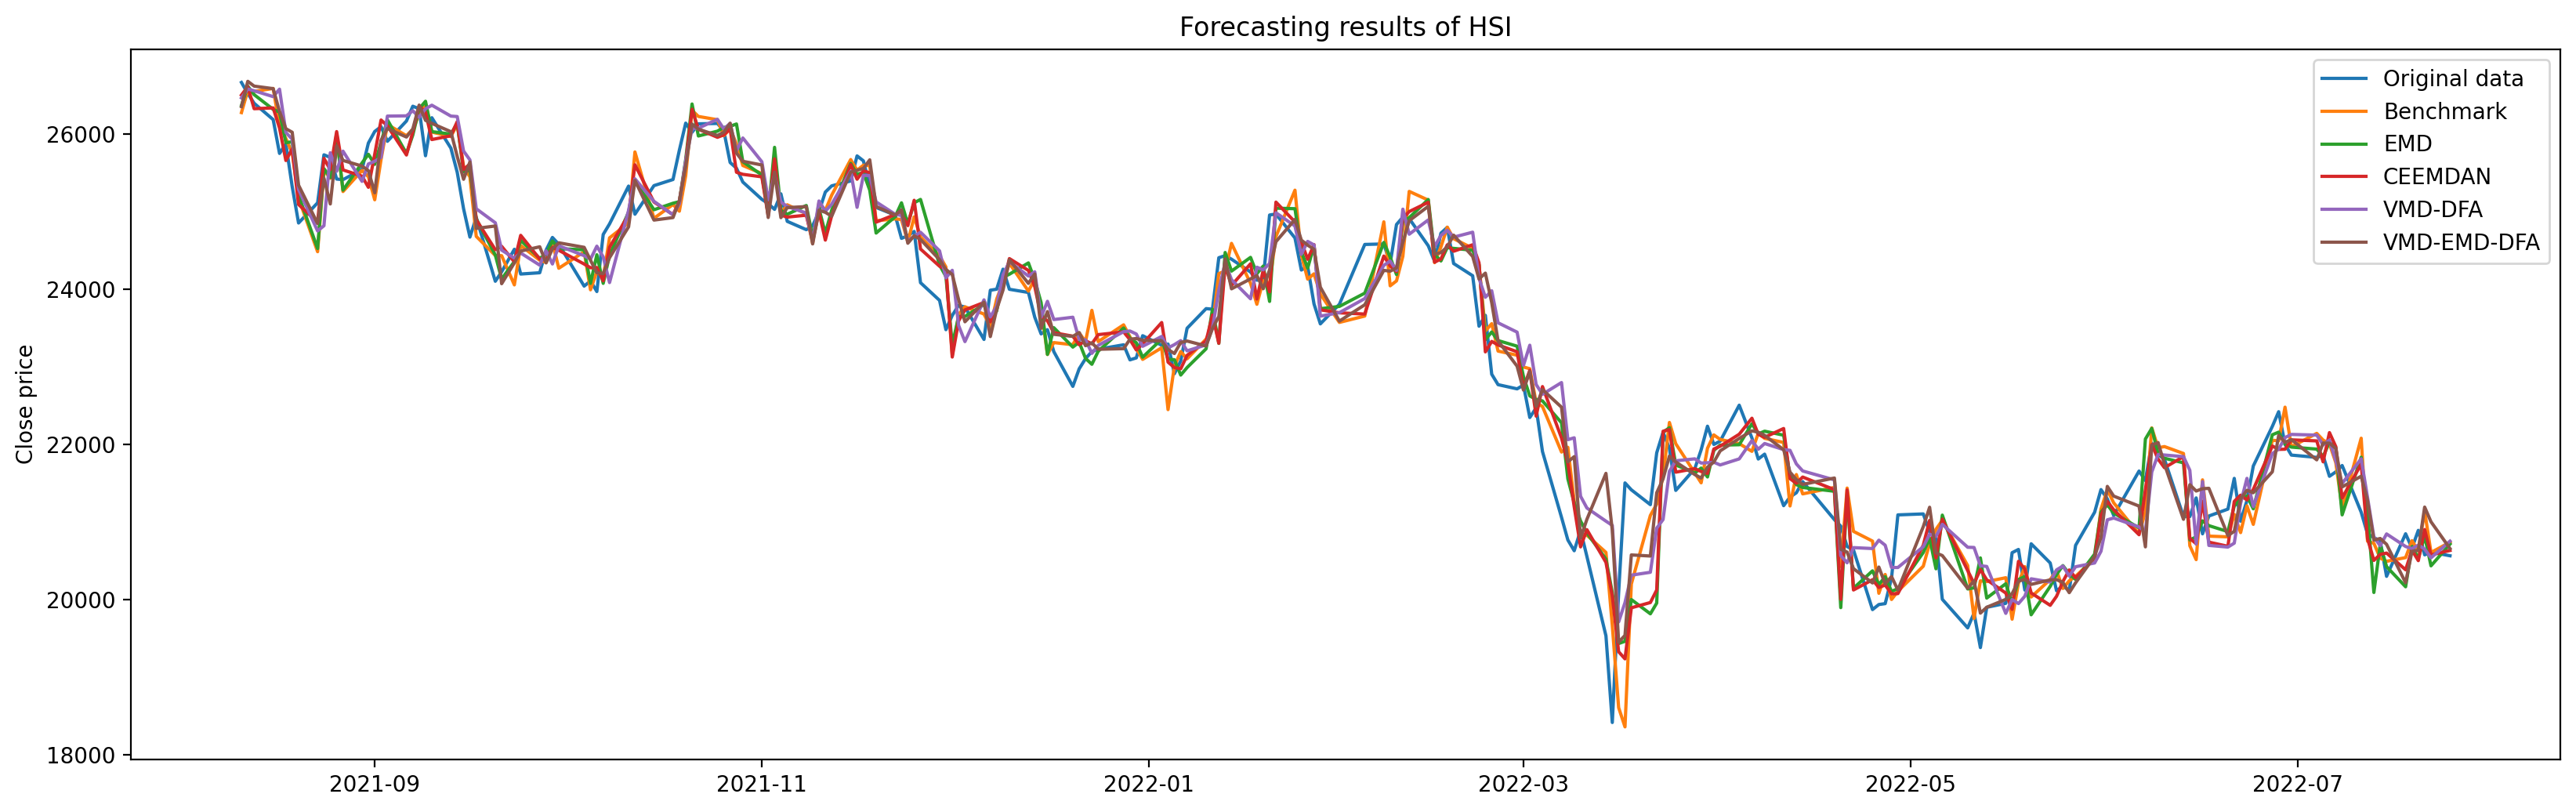

In [105]:
plt.figure(figsize=(20,6),dpi=200)
og = pd.Series(SERIES[-test_num:].values)
plt.plot(date,og,label= 'Original data') 
plt.plot(date,pred_Xgboost,label= 'Benchmark')
plt.plot(date,emd_pred_Xgboost,label= 'EMD')
plt.plot(date,ceemdan_pred_Xgboost,label= 'CEEMDAN')
plt.plot(date,VMD_Xgboost,label= 'VMD-DFA')
plt.plot(date,VMD_EMD_Xgboost,label= 'VMD-EMD-DFA')
plt.xlabel('')
plt.ylabel('Close price')
plt.title('Forecasting results of HSI')
plt.legend()
plt.savefig("./HSI prediction.jpg")
              
plt.show()